In [1]:
from dataset_manager import MovieLensManager
from explainability_module import MovieLensExplainabilityModule

In [2]:
df = MovieLensManager.load_dataset_from_hub("AhmadPython/MovieLens_KGE")
exp = MovieLensExplainabilityModule(df, init_pcas=True)

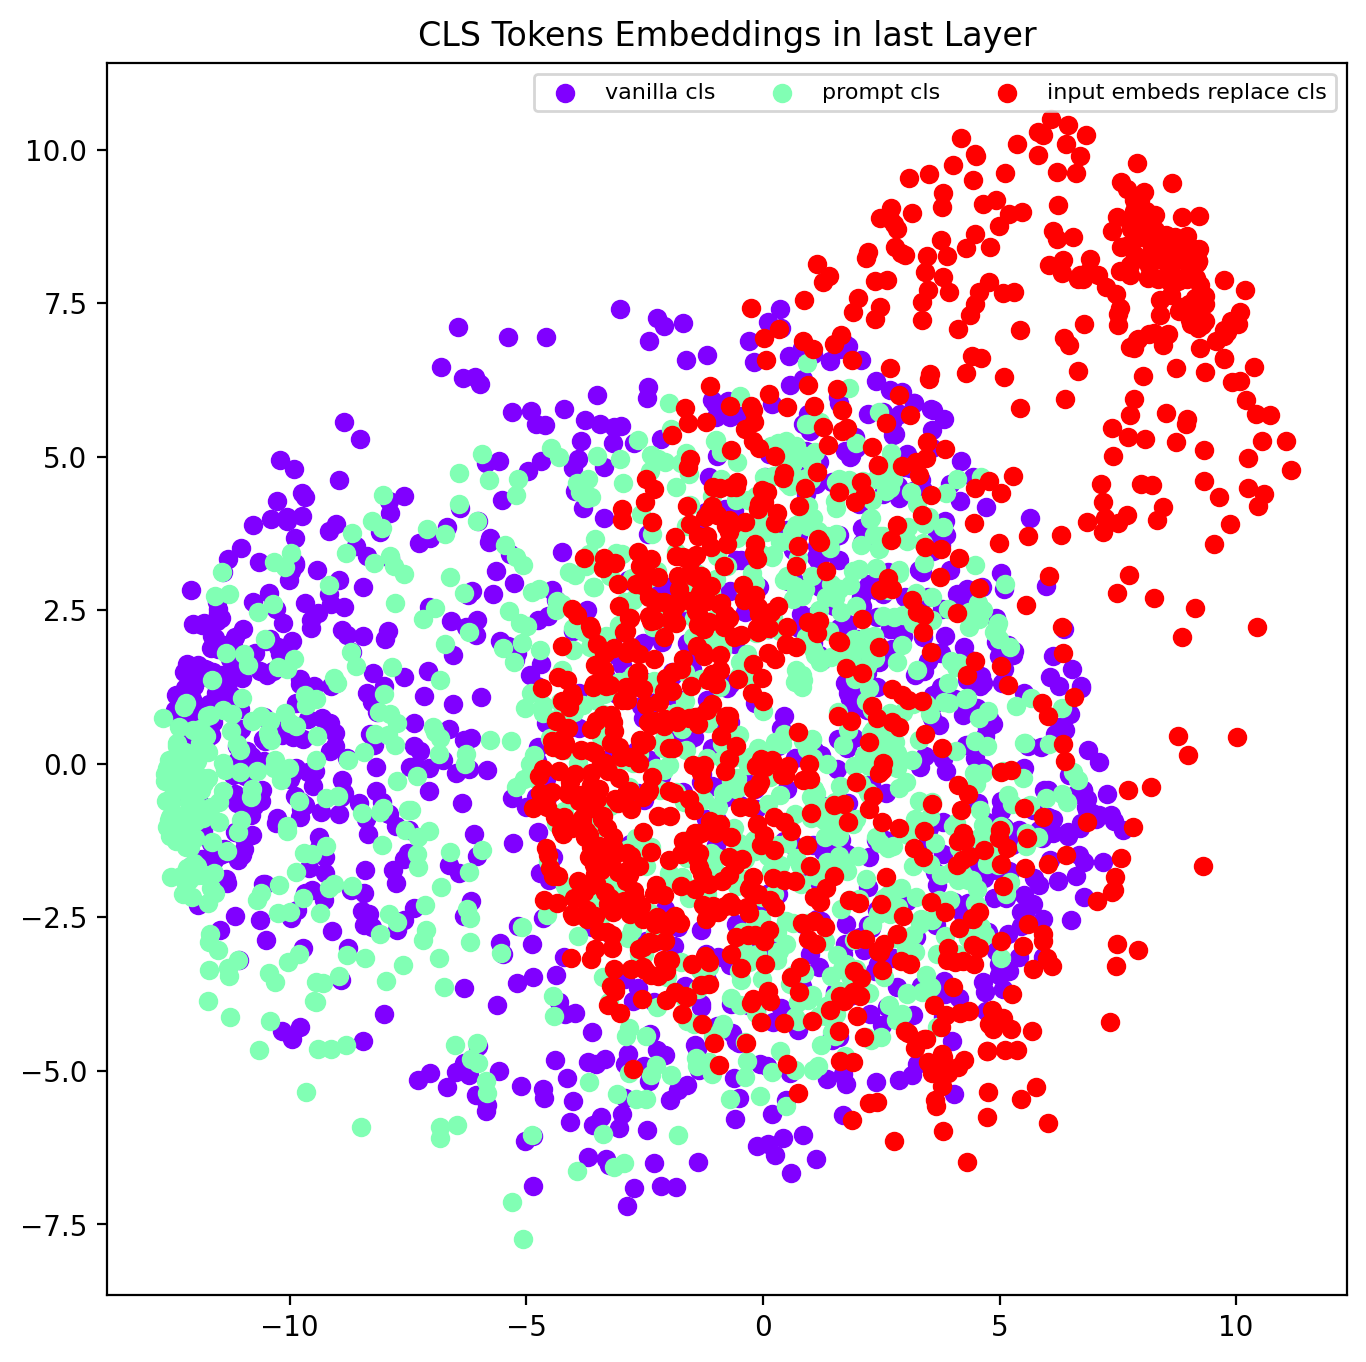

<Figure size 1600x1600 with 0 Axes>

In [7]:
exp.plot_cls_embeddings(samples=1000)

34284 17142 17142


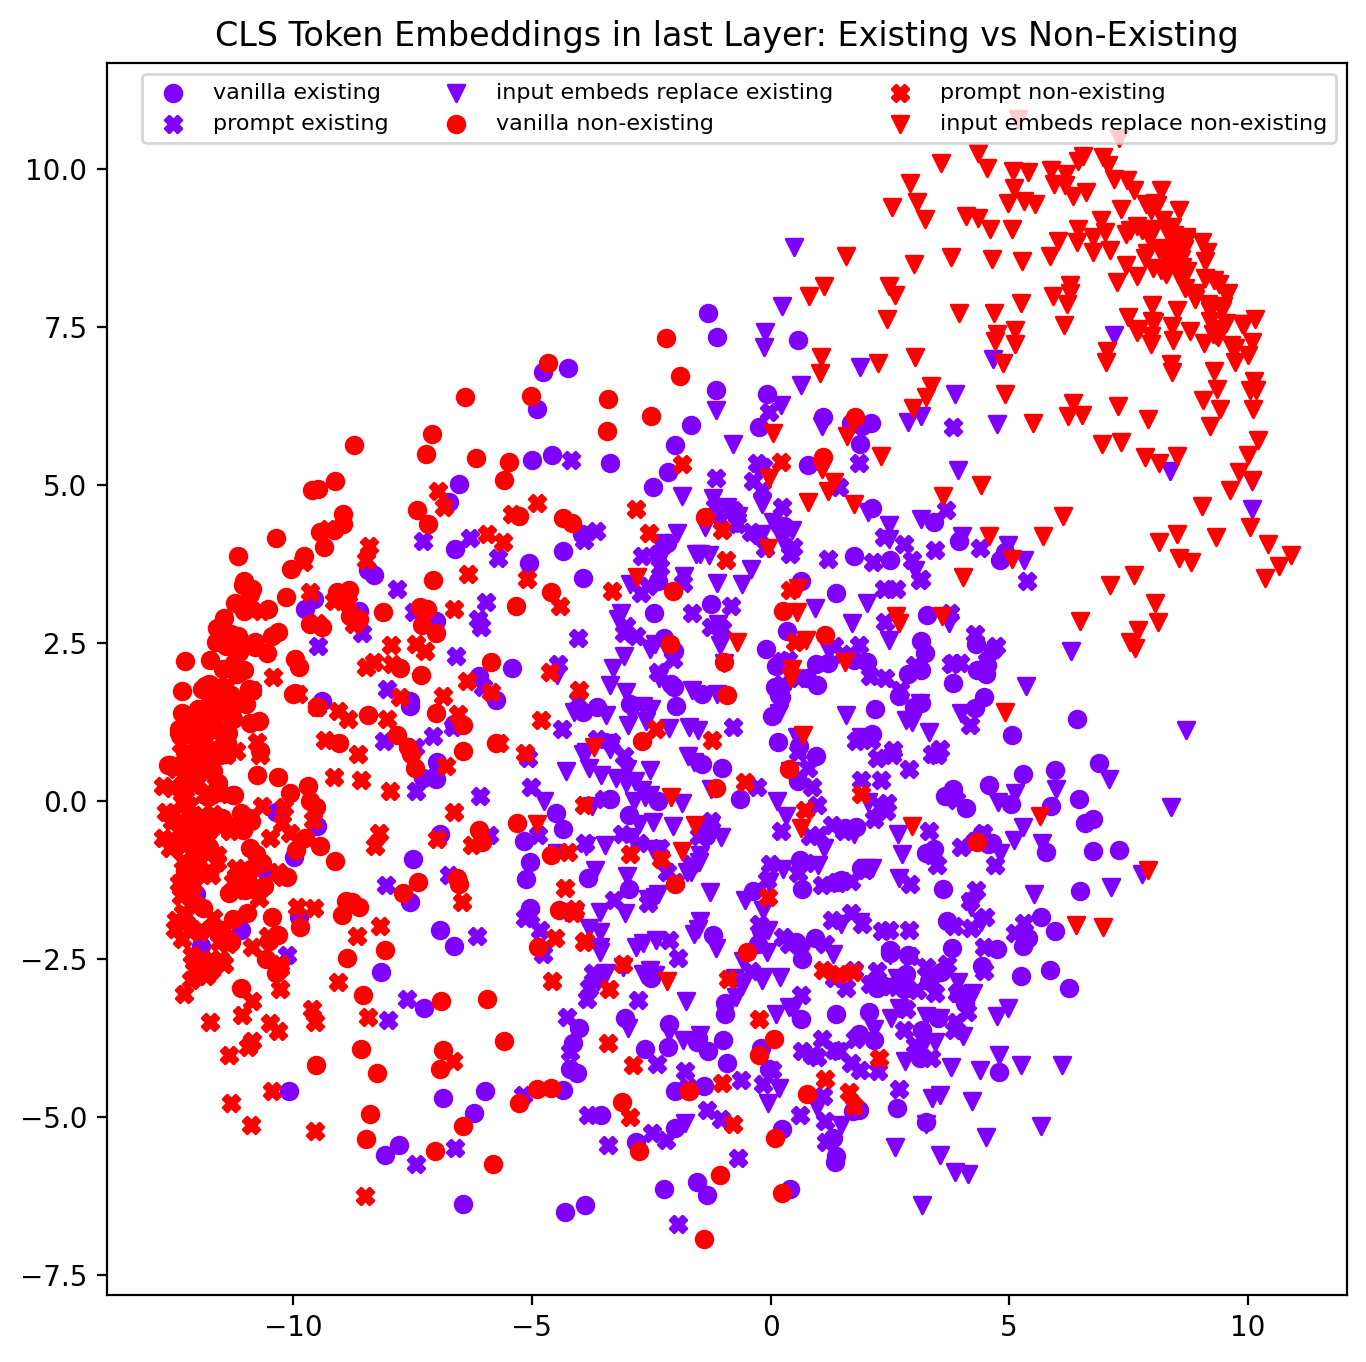

<Figure size 1600x1600 with 0 Axes>

In [4]:
exp.plot_cls_true_vs_non_true(samples=250, split="val")

(6, 3, 200, 2) (3, 3, 200, 2) (3, 3, 200, 2)


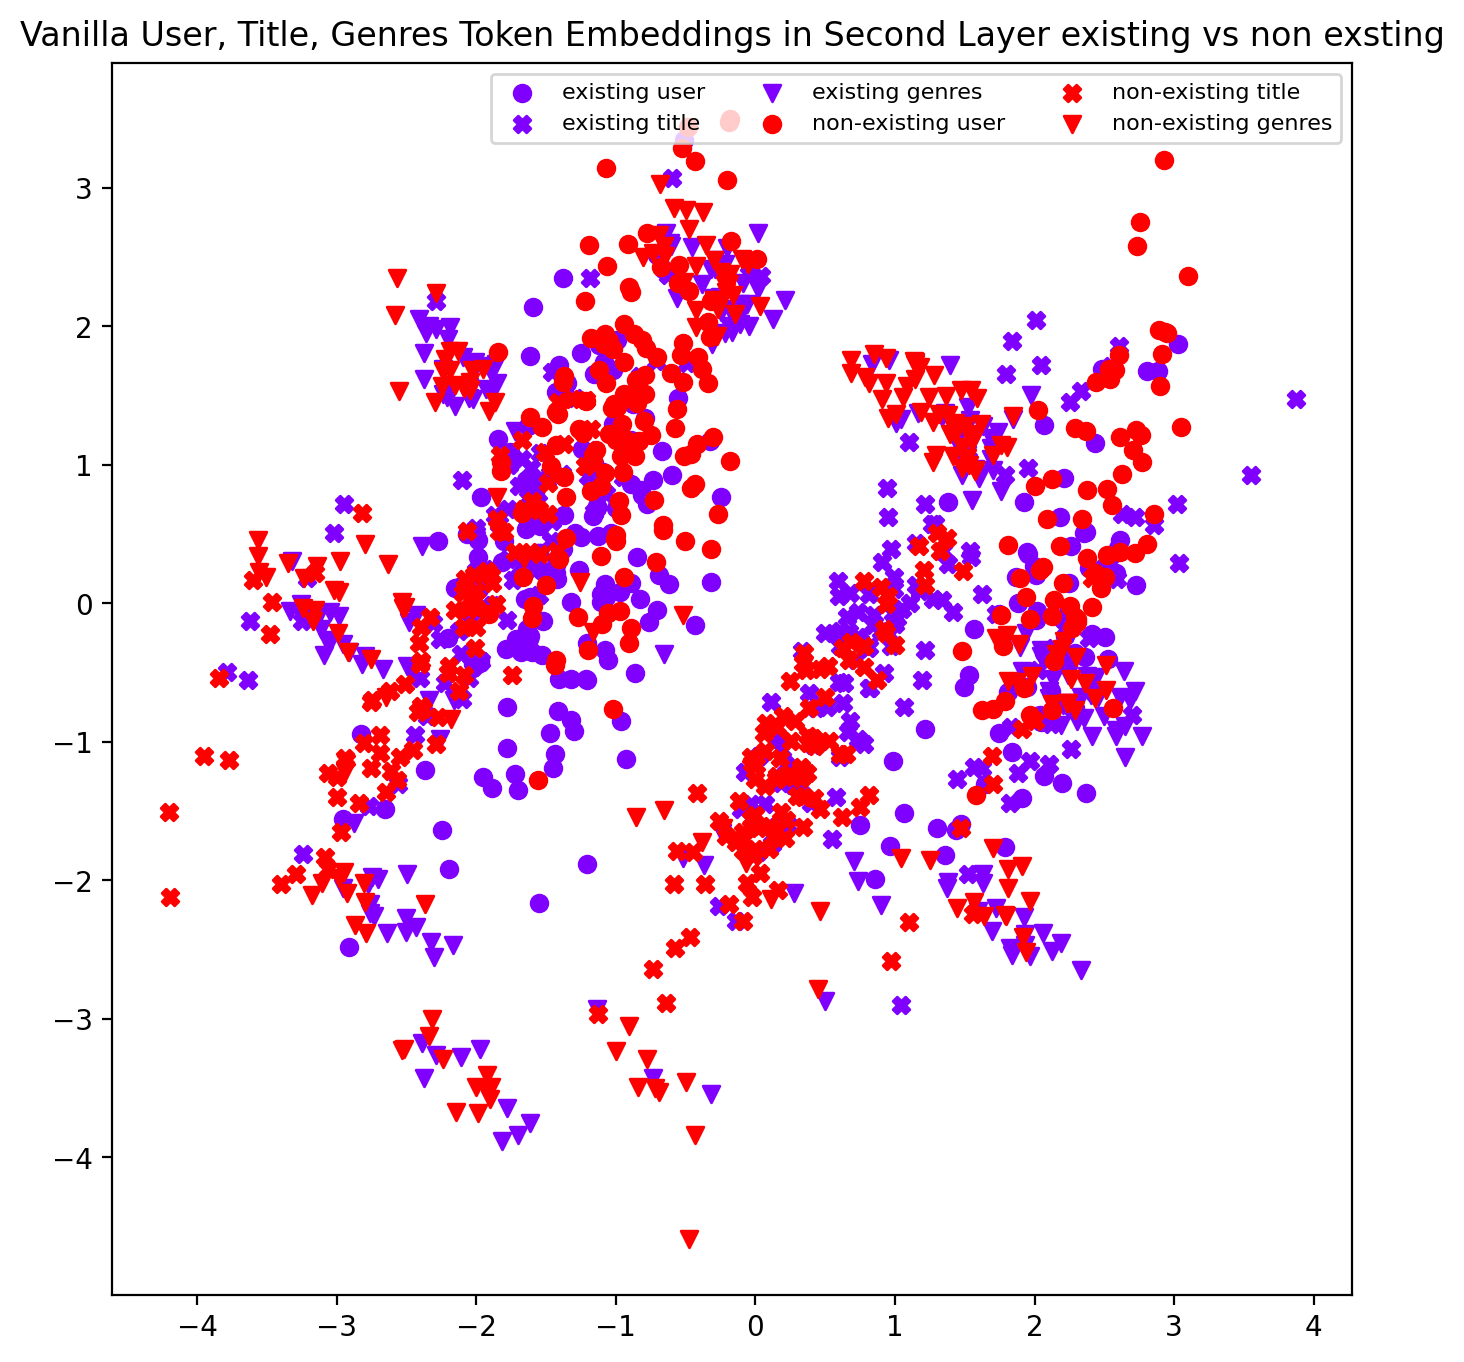

<Figure size 1600x1600 with 0 Axes>

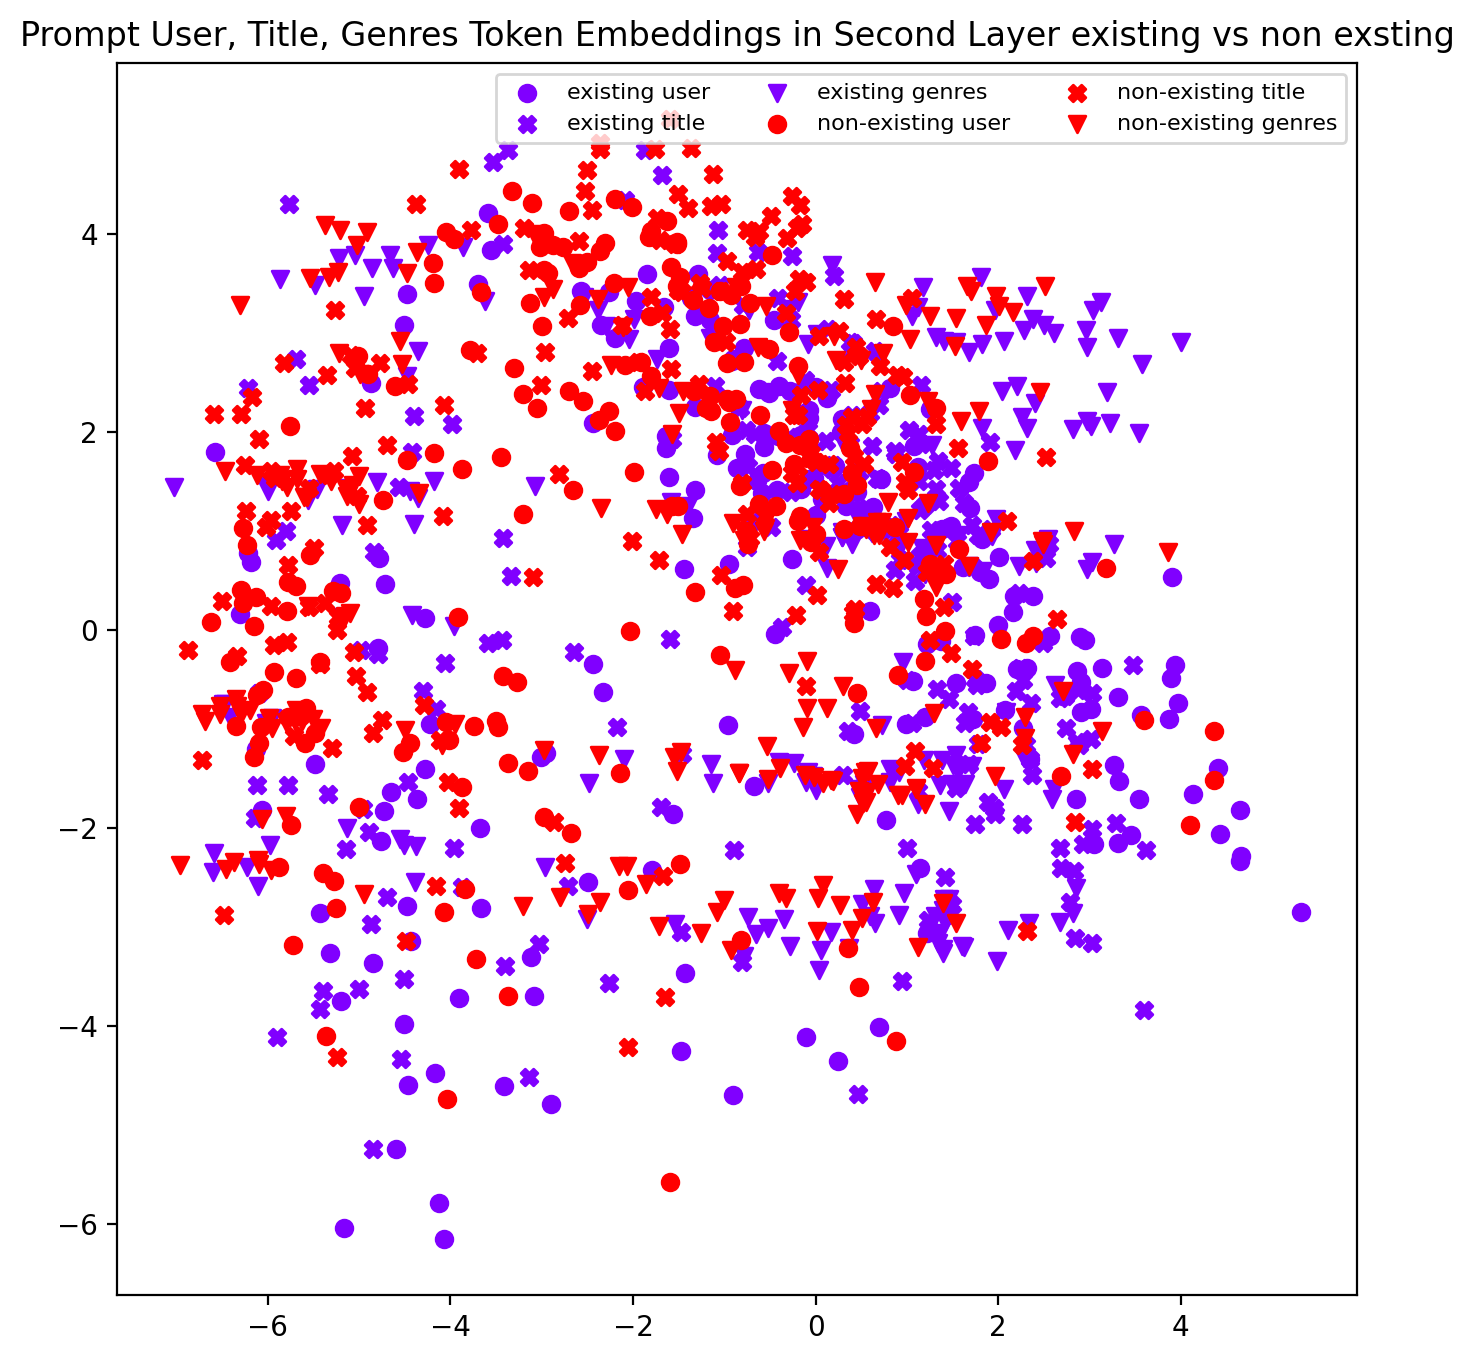

<Figure size 1600x1600 with 0 Axes>

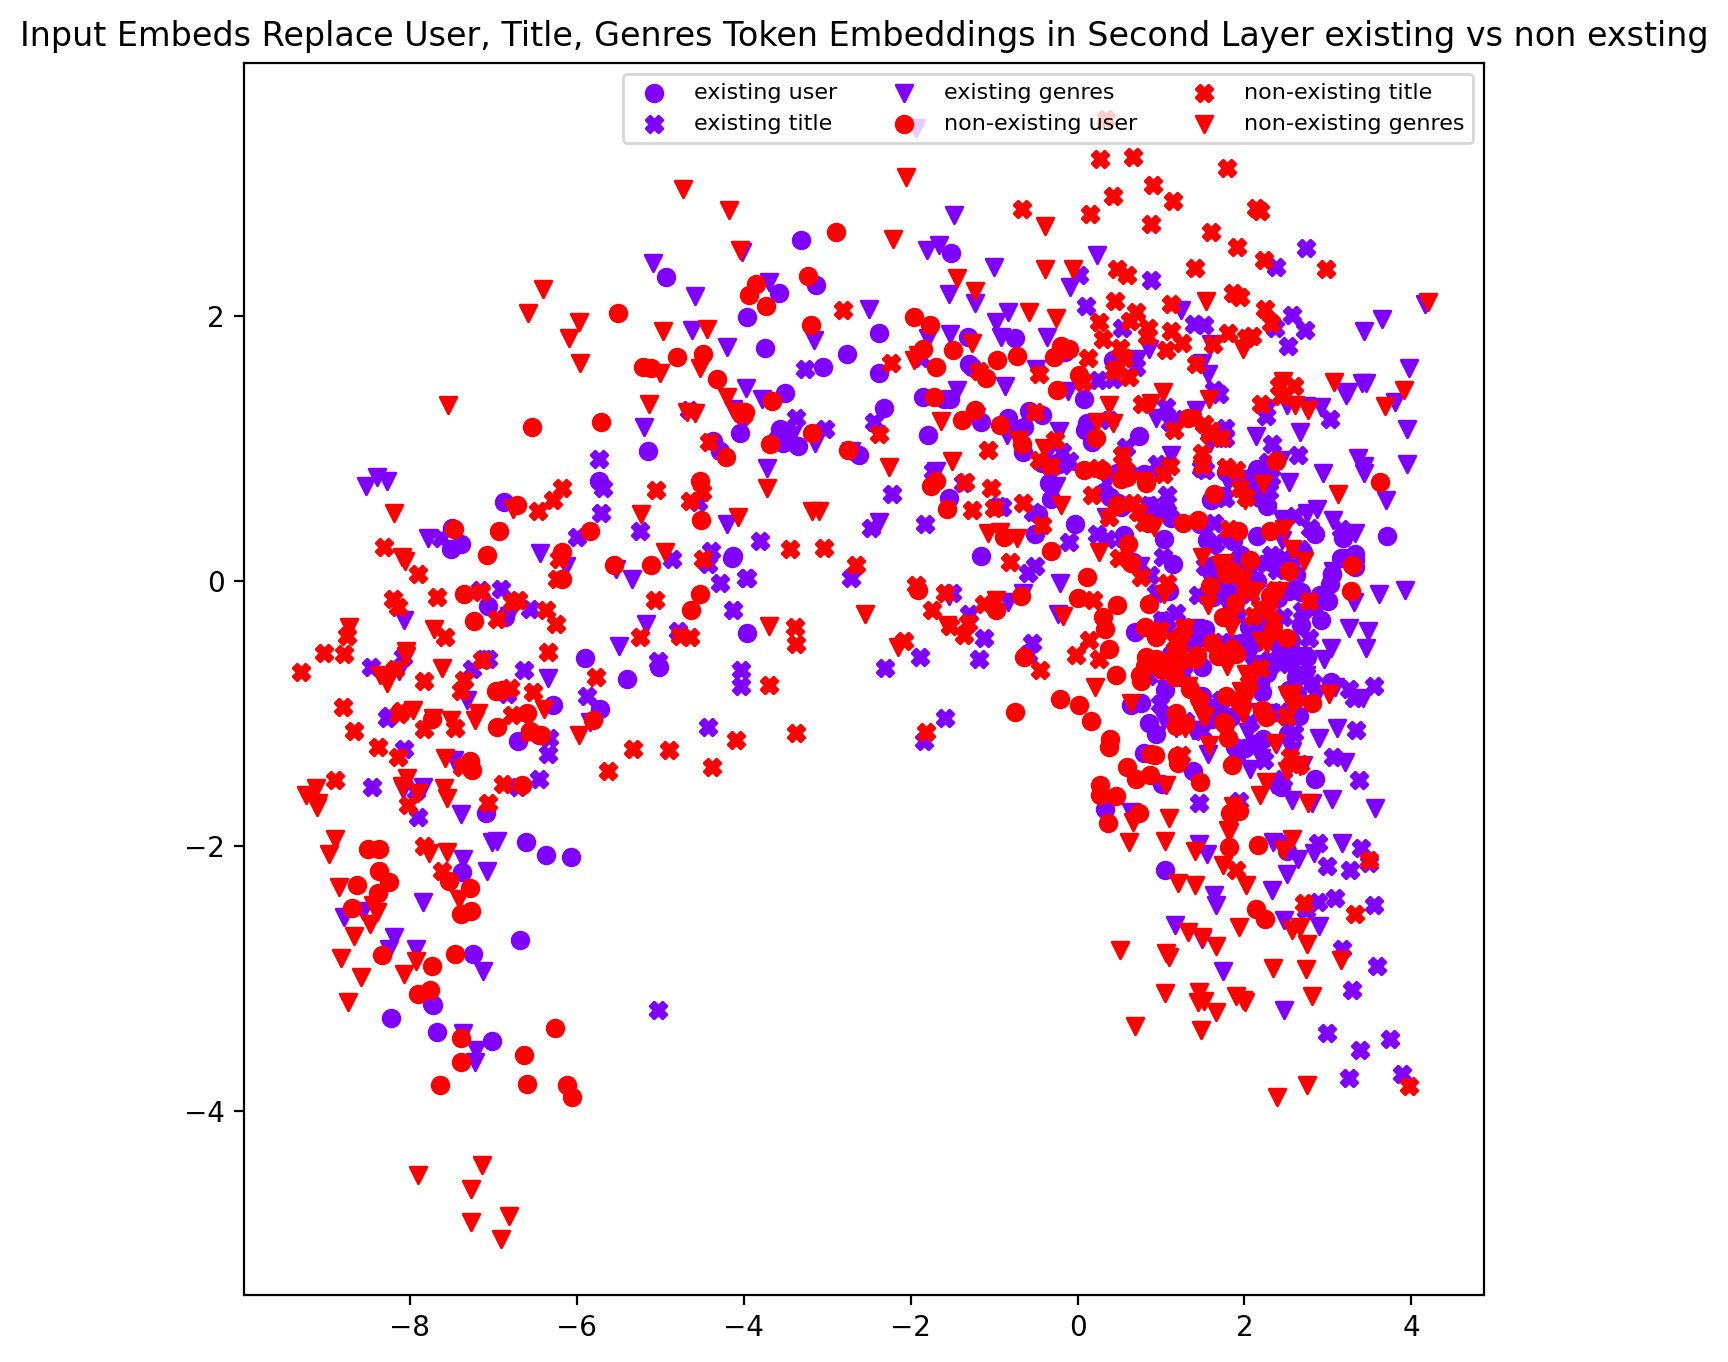

<Figure size 1600x1600 with 0 Axes>

In [5]:
exp.plot_user_movie_embeddings_in_second_layer_true_vs_non_true(samples=200)